# Hackathon Stat

This project illustrates the course LEPL1109 with an industrial application of statistics. You will analyse the capacity of solar production of electricity located in the French cities of Caen and Tours.
The file 'radiation.csv' contains 3 columns 
DATE           : YYYYMMDD,
Caen and Tours : the daily solar radiation in W/m2 measured in the 2 cities. 
Notice that data for some days are not reported due to failure of measurement system.

## Report content

•	You have to fill in this  jupyter notebook downloadable on the moodle website of the course

•	Grades are granted to the members whose names are in the Jupyter notebook. If your name doesn’t appear on the top of the notebook, you’ll get a 0, even though you are in a group on Moodle.

•	The jupyter notebook must be compiled with printed results and next submitted via moodle. The absence of compiled results (or non-printed values) leads to a lower grade.

## Report submission

•	The deadline for submission is reported on the moodle website. Submission after the deadline will not be accepted.

•	To submit your report, go to the section “APP” on Moodle and the subsection “Soumission du rapport”. You can upload your work there. Once you are sure that it is your final version, click the button “Envoyer le devoir”. It is important that you don’t forget to click on this button ! 

•	Reports that have not been uploaded through Moodle will not be corrected.

## Names and Noma of participants:

Part. 1: Lebras Floriane         (35022100)

Part. 2: Martin Antoine           (86692100)

Part. 3: Dallemagne Brieuc        (77122100)

Part. 4: De Vleeschouwver Nora    (48602100)

Part. 5: Debelle Thomas           (30002100)

Part. 6: Orékhoff Alexandre       (54552100)

---
## 1. Energy calculation and basic statistics

Compute the daily energy in WH per square meter of solar panel. For this purpose you use the datasets reporting the solar irradation measure in Tours and Tours (source https://www.ecad.eu/). The irradiation is measured in W/m2 per day. You will use the formula:

C = E_Sol x 24 x P_cr x f_perf

where  

C is the electricity produced in WH/m2 for a day

E_sol is the daily solar radiation in W/m2 

P_cr is the peak power coefficient, set here to  0.18 (monocristal silicium)

f_perf depends upon the system, set here to 0.75.

Remark:

1 W = 1 J/sec

1 WH  is 1W x 3600sec = 3600J

energy/m2 = E_sol * 24 * 3600 J/m2 = E_sol * 24 WH/m2

---
1.1. Start by computing the daily energy in WH produced by a 1m2 solar panel

a. Plot time-series of solar electric production in Caen and Tours from 1974 to 2023. Comment the evolution.

b. Plot boxplots of daily productions for both cities. Comment the box plot.

c. Remove outliers using the interquartile range. 

d. Plot an histogram of daily electricity production, after removal of outliers.

Watchout: remove all days for which a outlier is observed in Caen **or** Tours to keep the same number of observations.


In [104]:
### prérequis Import ###

import csv
import scipy as sp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

In [105]:
data_pd = pd.read_csv("Radiation.csv")
data_pd = data_pd.drop(columns="Unnamed: 0")
Caen = data_pd["Caen"].to_numpy()
Tours = data_pd["Tours"].to_numpy()
Date = data_pd["DATE"].to_numpy()
Index = np.arange(0, len(Date), 1)


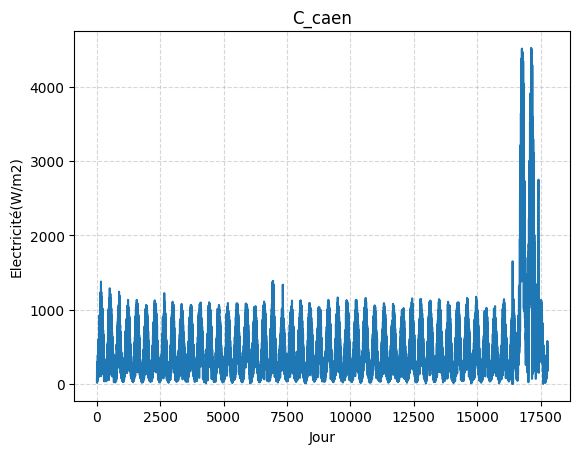

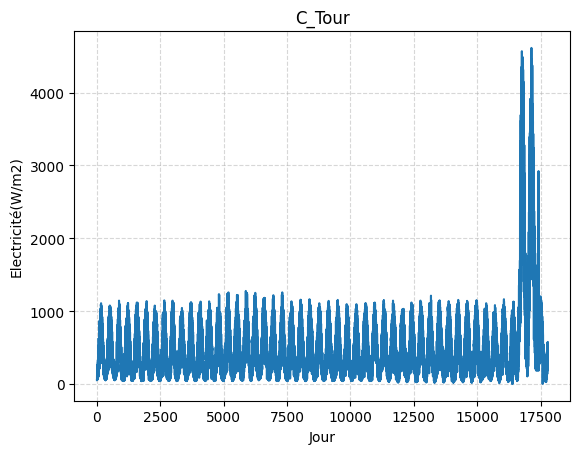

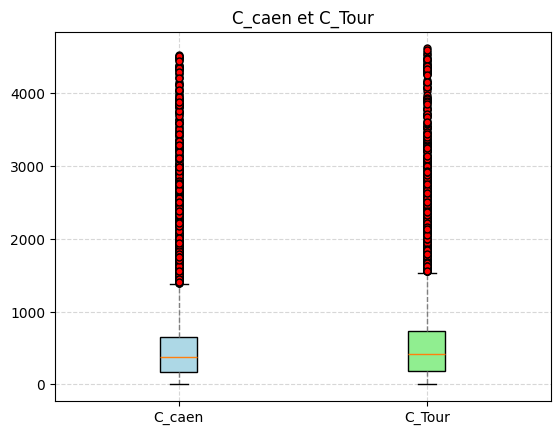

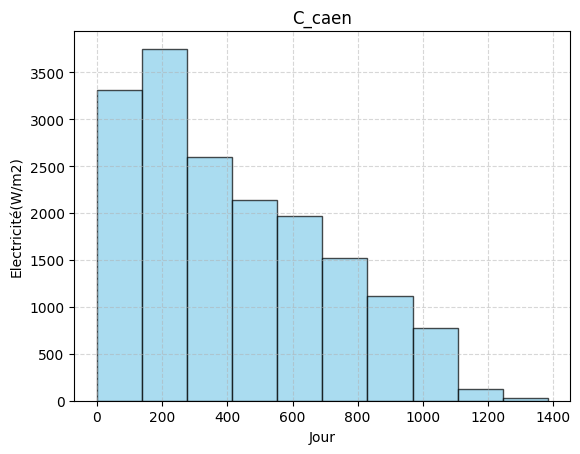

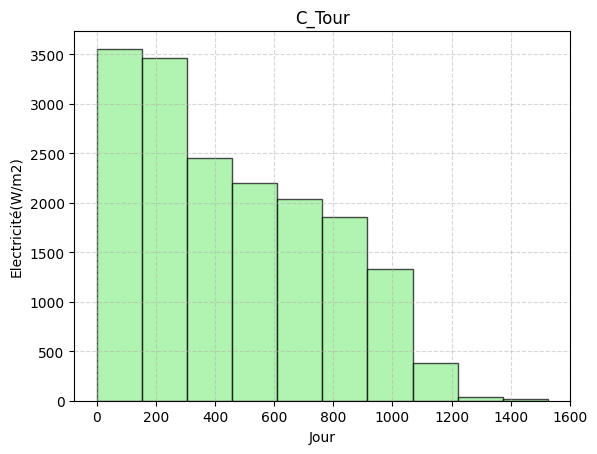

'\ncommentaire 1.1.a: sur les deux premiers plots on peut voir que à part certaines valeurs grandement supérieurs vers la fin,\nles données des deux villes restent dans une range entre 0 et 1500.\n\ncommentaire 1.1.b: les plots de boxplots nous confirment que la plupart valeurs sont dans une range entre 0 et 1500. \nOn peut voir que du côté de Tour la range est un peu plus grande que celle de Caen. On peut aussi voir que la médiane\nde Tour est un tout petit peu plus grande que celle de Caen.\n'

In [106]:
### code 1.1 ###

def time_to_year(dataset, month):
    dataset = dataset.copy()
    dataset["DATE"] = pd.to_datetime(dataset["DATE"], format="%Y%m%d")
    
    dataset["Year"] = dataset["DATE"].dt.year
    dataset["Month"] = dataset["DATE"].dt.month
    dataset = dataset[dataset["Month"] == month]
    dataset = dataset.drop(columns=["Year", "Month"])    
    
    dataset["DATE"] = dataset["DATE"].dt.strftime("%Y") ## Make a copy if you want to keep the most interesting data
    return dataset

def time_to_month(dataset):
    dataset = dataset.copy()
    dataset["DATE"] = pd.to_datetime(dataset["DATE"], format="%Y%m%d")
    dataset["DATE"] = dataset["DATE"].dt.strftime("%m") ## Make a copy if you want to keep the most interesting data
    return dataset


def box_plot(data1, data2, title, name1, name2):
    """
    description:
        plot a box plot of two data

    args:
        data1: list of data
        data2: list of data
        title: title of the plot
        name1: name of the first data
        name2: name of the second data

    return:
        None
    """
    
    plt.figure()
    bp = plt.boxplot([data1, data2], patch_artist=True, labels=[name1, name2])
    
    colors = ['lightblue', 'lightgreen']
    for box, color in zip(bp['boxes'], colors):
        box.set(facecolor=color)
    
    for whisker in bp['whiskers']:
        whisker.set(color='gray', linestyle='--', linewidth=1)
    
    for flier in bp['fliers']:
        flier.set(marker='o', markersize=5, markerfacecolor='red')
    
    plt.title(title)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()


def plot_data(data,title,Xname,Yname):
    """
    description:
        plot a data
    
    args:
        data: list of data
        title: title of the plot
        Xname: name of the X axis
        Yname: name of the Y axis

    return:
        None
    """
    
    plt.figure()
    plt.plot(data)
    plt.title(title)
    plt.xlabel(Xname)
    plt.ylabel(Yname)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

def remove_outliers_interquartile(lst1,lst2,Date,Index):
    """
    description:
        remove outliers from two lists of data by using the interquartile method

    args:
        lst1: np.array of data1
        lst2: np.array of data2

    return:
        new_lst1: list of data1 without outliers
        new_lst2: list of data2 without outliers
        new_date: list of dates without outliers
        new_index: list of indexes of the data without outliers
    """
    q1 = np.percentile(lst1, 25)
    q3 = np.percentile(lst1, 75)
    iqr = q3 - q1
    Q1 = np.percentile(lst2,25)
    Q3 = np.percentile(lst2,75)
    IQR = Q3 - Q1
    new_lst1 = list()
    new_lst2 = list()
    new_date = list()
    new_index = list()
    for i in range(len(lst1)):
        if lst1[i] > q1 - 1.5*iqr and lst1[i] < q3 + 1.5*iqr and lst2[i] > Q1 - 1.5*IQR and lst2[i] < Q3 + 1.5*IQR:
            new_lst1.append(lst1[i])
            new_lst2.append(lst2[i])
            new_date.append(Date[i])
            new_index.append(Index[i])
    return [new_lst1,new_lst2,new_date,new_index]

def plot_histogram(data, title, x_label, y_label, color='skyblue'):
    """
    description:
        plot an histogram of a data
    
    args:
        data: list of data
        title: title of the plot
        x_label: name of the X axis
        y_label: name of the Y axis
        color: color of the histogram
    
    Return: 
        None
    """
    
    plt.figure()
    plt.hist(data, color=color, edgecolor='black', alpha=0.7)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.grid(True, linestyle='--', alpha=0.5)

    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

    plt.show()

P_cr = 0.18
f_perf = 0.75
E_caen = Caen
E_Tour = Tours
C_caen = Caen*24*P_cr*f_perf
C_Tour = Tours*24*P_cr*f_perf


plot_data(C_caen,'C_caen','Jour','Electricité(W/m2)')
plot_data(C_Tour,'C_Tour','Jour','Electricité(W/m2)')

box_plot(C_caen,C_Tour,'C_caen et C_Tour','C_caen','C_Tour')

res = remove_outliers_interquartile(C_caen,C_Tour,Date,Index)
C_caen = res[0]
C_Tour = res[1]
Date = res[2]
Index = res[3]

plot_histogram(C_caen,'C_caen','Jour','Electricité(W/m2)')
plot_histogram(C_Tour,'C_Tour','Jour','Electricité(W/m2)',color='lightgreen')

"""
commentaire 1.1.a: sur les deux premiers plots on peut voir que à part certaines valeurs grandement supérieurs vers la fin,
les données des deux villes restent dans une range entre 0 et 1500.

commentaire 1.1.b: les plots de boxplots nous confirment que la plupart valeurs sont dans une range entre 0 et 1500. 
On peut voir que du côté de Tour la range est un peu plus grande que celle de Caen. On peut aussi voir que la médiane
de Tour est un tout petit peu plus grande que celle de Caen.
"""


---
1.2. We want to compute monthly statistics of electricity solar production. Calculate for each city and for each month: 

1) the average daily production of electricity in Wh/m2

2) the median daily production of electricity in Wh/m2

3) the standard deviation daily production of electricity in Wh/m2

4) the 5% percentile of daily production of electricity in Wh/m2

5) the 95% percentile of daily production of electricity in Wh/m2

Report the results in one or two tables. 

Compare and comment these statistics!

In [107]:
### code 1.2 ###

### Refaire avec les mois

def q2_month(dataset, month):
    """Code that answer the question 1.2
    description:
        Compute the average, median, standard deviation, 5 percentile and 95 percentile of a dataset

    Args:
        dataset (Arraylist): An arraylist with the data of the daily production of electricity

    Returns:
        tuple: Return a tuple of data like: (average, median, standard deviation, 5 percentile, 95 percentile)
    """
    dataset_av = np.sum(dataset) / len(dataset) # Average / mean

    ### Comput median
    dataset_median = np.median(dataset)

    dataset_std = np.std(dataset)

    dataset_5 = np.percentile(dataset, 5)
    dataset_95 = np.percentile(dataset, 95)
        
    print(f"{month}:  {dataset_av:.5f}\t{dataset_median:.5f}\t{dataset_std:.5f}\t{dataset_5:.2f}\t{dataset_95:.2f}")
    
    return (dataset_av, dataset_median, dataset_std, dataset_5, dataset_95)

def q2(dataset):
    """Answer Q2

    Args:
        dataset (pandas dataframe): a data frame with the data column being the month
    """
    months = ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12"]
    cities = ["Caen", "Tours"]
    dataset = dataset.sort_values(by=["DATE"])
    
    #print(dataset)
    
    for city in cities:
        print(city)
        print("Month: Average  Median \t\tStandard dev \t5 quar  95 quartile")
        for month in months:
            q2_month(dataset[dataset["DATE"] == month][city].to_numpy(), month)
        print("_______________")

clean_pd = pd.DataFrame({"DATE": Date,"Caen": C_caen, "Tours": C_Tour})
month_pd = time_to_month(clean_pd.copy())
q2(month_pd)


Caen
Month: Average  Median 		Standard dev 	5 quar  95 quartile
01:  146.87512	123.12000	113.12286	42.12	304.56
02:  250.50206	223.56000	169.28194	70.79	466.56
03:  377.93608	359.64000	186.44511	126.36	654.48
04:  560.37074	573.48000	210.37179	204.12	874.80
05:  677.07922	703.08000	255.00834	233.28	1033.56
06:  736.63983	751.68000	265.78287	291.60	1108.08
07:  725.44217	738.72000	241.27005	317.52	1065.96
08:  623.10085	638.28000	197.94861	282.69	913.68
09:  459.97846	466.56000	168.72645	181.93	709.56
10:  282.71177	268.92000	154.33043	88.61	492.48
11:  173.02584	155.52000	124.72276	48.60	314.28
12:  114.45931	100.44000	83.63380	29.16	207.36
_______________
Tours
Month: Average  Median 		Standard dev 	5 quar  95 quartile
01:  158.13459	123.12000	134.63830	45.36	332.42
02:  273.32112	236.52000	194.81085	71.28	525.37
03:  417.67127	414.72000	197.80800	136.08	714.58
04:  600.14858	622.08000	225.84364	205.74	926.64
05:  705.47186	735.48000	251.81975	246.73	1049.76
06:  792.37957	826.20000	2

## Comment
We can see how the power production drastically increase during summer (eg: June and July) and in the opposite dropping during winter.
However there is a strong fluctuation in power production (standard deviation). It's normal since a bright sunny day produces way more than a grey and rainy day.

---
## 2. Fit of distributions and hypothesis tests

---
2.1. We focus on the daily production of electricity in April. Retrieve the data for month of April, in Caen and Tours. 

 1) Fit Gamma and normal distributions by log-likelihood maximization to 
    daily production of electricity during April (Caen & Tours).
    
 2) Compute the 4 log-likelihoods and select the best model for each location (justify your answer).
 
 3) Compare on the same plot the empirical, the  gamma and normal pdf (the
    empirical pdf is an histogram of frequencies).
    
 4) Why is there 3 parameters in python for the Gamma pdf whereas there
    is only 2 in the distribution seen during lectures? 

Remark : set floc to -0.001 for the gamma.fit (to avoid troubles in case of null observations)


In [108]:
#code here
april_pd = clean_pd.copy()
april_pd["DATE"] = pd.to_datetime(april_pd["DATE"], format="%Y%m%d")
april_pd["DATE"] = april_pd["DATE"].dt.strftime("%m")
april_pd = april_pd.loc[april_pd["DATE"] == "04"]

april_Caen, april_Tours = april_pd["Caen"].to_numpy(), april_pd["Tours"].to_numpy()
april_C_Caen = april_Caen*24*P_cr*f_perf
april_C_Tours = april_Tours*24*P_cr*f_perf
april_C_Caen, april_C_Tours, april_date, april_index = remove_outliers_interquartile(april_C_Caen,april_C_Tours, Date, Index)
print(april_C_Caen)
print(april_C_Tours)

norm_fit_Caen_loc, norm_fit_Caen_scale = sp.stats.norm.fit(april_C_Caen)
norm_fit_Tours_loc, norm_fit_Tours_scale = sp.stats.norm.fit(april_C_Tours)
x_norm_Caen  = np.linspace(sp.stats.norm.ppf(0.01,loc=norm_fit_Caen_loc,scale=norm_fit_Caen_scale), sp.stats.norm.ppf(0.99,loc=norm_fit_Caen_loc,scale=norm_fit_Caen_scale), 100)
x_norm_Tours = np.linspace(sp.stats.norm.ppf(0.01,loc=norm_fit_Tours_loc,scale=norm_fit_Tours_scale), sp.stats.norm.ppf(0.99,loc=norm_fit_Tours_loc,scale=norm_fit_Tours_scale), 100)
norm_pdf_Caen = sp.stats.norm.pdf(x_norm_Caen,norm_fit_Caen_loc,norm_fit_Caen_scale)
norm_pdf_Tours = sp.stats.norm.pdf(x_norm_Tours,norm_fit_Tours_loc,norm_fit_Tours_scale)
normal_log_likelihood_maximisation_Caen = np.sum(np.log(norm_pdf_Caen))
normal_log_likelihood_maximisation_Tours = np.sum(np.log(norm_pdf_Tours))
print(normal_log_likelihood_maximisation_Caen)
print(normal_log_likelihood_maximisation_Tours)


gamma_fit_Caen_shape, gamma_fit_Caen_loc, gamma_fit_Caen_scale = sp.stats.gamma.fit(april_C_Caen,floc=-0.001)
gamma_fit_Tours_shape, gamma_fit_Tours_loc, gamma_fit_Tours_scale = sp.stats.gamma.fit(april_C_Tours,floc=-0.001)
x_gamma_Caen  = np.linspace(sp.stats.gamma.ppf(0.01,a= gamma_fit_Caen_shape,loc=gamma_fit_Caen_loc,scale=gamma_fit_Caen_scale), sp.stats.gamma.ppf(0.99,a=gamma_fit_Caen_shape,loc=gamma_fit_Caen_loc,scale=gamma_fit_Caen_scale), 100)
x_gamma_Tours = np.linspace(sp.stats.gamma.ppf(0.01,a= gamma_fit_Tours_shape,loc=gamma_fit_Tours_loc,scale=gamma_fit_Tours_scale), sp.stats.gamma.ppf(0.99,a=gamma_fit_Tours_shape,loc=gamma_fit_Tours_loc,scale=gamma_fit_Tours_scale), 100)
gamma_pdf_Caen = sp.stats.gamma.pdf(x_gamma_Caen,gamma_fit_Caen_shape,gamma_fit_Caen_loc,gamma_fit_Caen_scale)
gamma_pdf_Tours = sp.stats.gamma.pdf(x_gamma_Tours,gamma_fit_Tours_shape,gamma_fit_Tours_loc,gamma_fit_Tours_scale)
gamma_log_likelihood_maximisation_Caen = np.sum(np.log(gamma_pdf_Caen))
gamma_log_likelihood_maximisation_Tours = np.sum(np.log(gamma_pdf_Tours))
print(gamma_log_likelihood_maximisation_Caen)
print(gamma_log_likelihood_maximisation_Tours)

if normal_log_likelihood_maximisation_Caen > gamma_log_likelihood_maximisation_Caen:
    log_likelihood_maximisation_Caen = normal_log_likelihood_maximisation_Caen
else:
    log_likelihood_maximisation_Caen = gamma_log_likelihood_maximisation_Caen
if normal_log_likelihood_maximisation_Tours > gamma_log_likelihood_maximisation_Tours:
    log_likelihood_maximisation_Tours = normal_log_likelihood_maximisation_Tours
else:
    log_likelihood_maximisation_Tours = gamma_log_likelihood_maximisation_Tours

[1490.6591999999998, 1721.6064, 1406.6783999999998, 1868.5728, 1816.0847999999999, 1196.7264, 2246.4864, 2393.4528, 2718.8783999999996, 2750.371199999999, 1774.0944, 2918.3327999999997, 1900.0655999999994, 2970.8207999999995, 1511.6544, 2981.3183999999997, 1931.5584, 1921.0607999999997, 2897.3376000000003, 2550.9168, 1763.5967999999996, 745.3295999999999, 2173.0032, 1721.6064, 1816.0847999999999, 1270.2096000000001, 629.8559999999999, 1532.6496000000002, 2813.3567999999996, 2435.4431999999997, 1448.6688000000001, 650.8512, 1679.616, 1175.7311999999997, 2120.5152, 1658.6207999999997, 1637.6255999999994, 1784.5919999999996, 2110.0176, 1889.568, 1805.5872, 1133.7408, 1123.2432, 1007.7695999999999, 1018.2672, 1742.6016, 1564.1424000000002, 671.8464, 1207.224, 2918.3327999999997, 2918.3327999999997, 2907.8351999999995, 1711.1088, 1648.1231999999998, 3138.782399999999, 1648.1231999999998, 3285.7487999999994, 3233.260799999999, 1763.5967999999996, 2939.328, 1984.0464, 755.8272, 2508.9264, 222

2.1.2:

The distribution model with a bigger log likelihood maximisation is the better one. (-> check why)

==> The bigger is the log likelihood maximisation, the closer we are to our data.

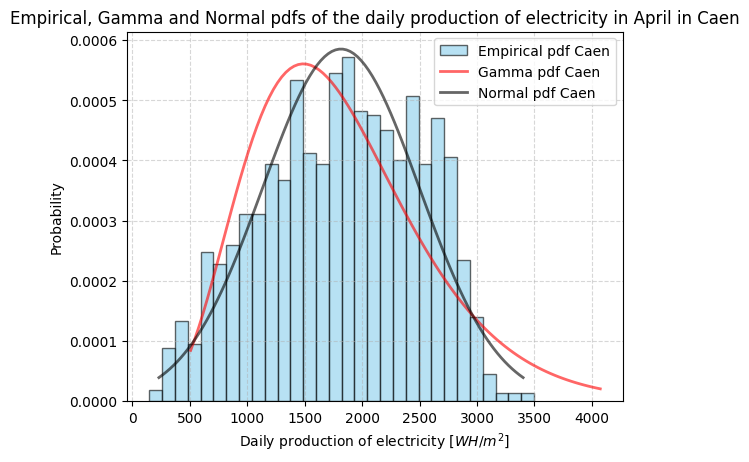

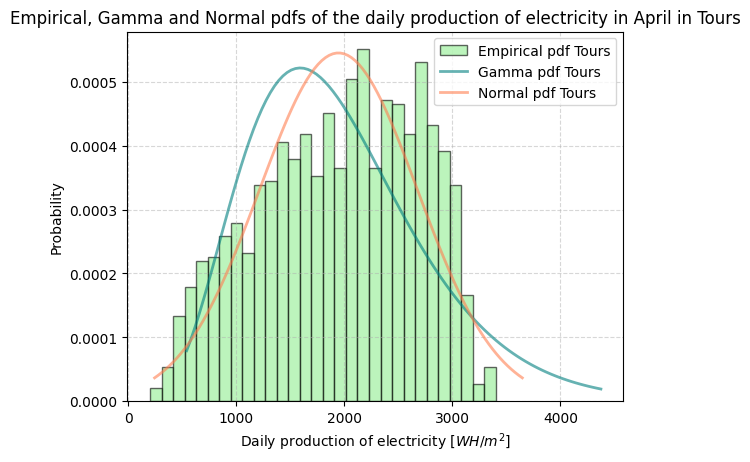

In [109]:
fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()
ax1.grid(True, linestyle='--', alpha=0.5)
ax2.grid(True, linestyle='--', alpha=0.5)
ax1.set_title('Empirical, Gamma and Normal pdfs of the daily production of electricity in April in Caen')
ax2.set_title('Empirical, Gamma and Normal pdfs of the daily production of electricity in April in Tours')
ax1.set_xlabel(r'Daily production of electricity $[WH/m^2]$')
ax1.set_ylabel('Probability')
ax2.set_xlabel('Daily production of electricity $[WH/m^2]$')
ax2.set_ylabel('Probability')
n, bins, patches = ax1.hist(april_C_Caen, 30, density=1,facecolor='skyblue', edgecolor='black', alpha=0.6, label='Empirical pdf Caen')
n, bins, patches = ax2.hist(april_C_Tours, 30, density=1,facecolor='lightgreen', edgecolor='black', alpha=0.6, label='Empirical pdf Tours')
ax1.plot(x_gamma_Caen, gamma_pdf_Caen,'r-', lw=2, alpha=0.6, label='Gamma pdf Caen')
ax2.plot(x_gamma_Tours, gamma_pdf_Tours,'teal', lw=2, alpha=0.6, label='Gamma pdf Tours')
ax1.plot(x_norm_Caen, norm_pdf_Caen,'k-', lw=2, alpha=0.6, label='Normal pdf Caen')
ax2.plot(x_norm_Tours, norm_pdf_Tours,'coral', lw=2, alpha=0.6, label='Normal pdf Tours')
ax1.legend()
ax2.legend()

2.1.4:

(to check)

(3 parameters = a,loc,scale ? compared to alpha, beta in lectures ?)

a==>shape of the distribution = alpha in lectures

loc==>location (mean?)

scale==> 1/beta in lectures

Paramètre 'loc' en plus --> shifts the distribution around loc. Without loc and scale specified (loc=0 and scale=1 by default), the pdf is in the standardized form.

---

2.2. Check if the average daily production in April is the same in Caen and Tours. Let us recall that the null hypothesis is

$H_0$: $\mu_{Caen} = \mu_{Tours}$.

Take care to comment your conclusions. Are all assumptions required to perform this test sastisfied?

In [110]:
X, Y, april_date, april_index = remove_outliers_interquartile(april_C_Caen,april_C_Tours, Date, Index)



Ttest=sp.stats.ttest_ind(X,Y)
#I check if the pvalue(=smallest level of significance for which 
# the data indicate rejection of the null hypothesis) is bigger then alpha to keep H0
#I choose alpha=5%
if Ttest.pvalue<0.05:
    print("H0 is rejected")
else:
    print("H0 is not rejected")

#Having the same variance is required to perform this test and the populations need 
# to have a normal distribution and be i.i.d. . As we see in the first part of question 2, the normal 
# distribution is the best when we do a log likelihood maximisation. I test the equality 
# of variance at the next question and we can see that H0 is rejected so the variance are not the same.
#H0 is rejected which means that the average daily production is not the same in Caen and Tours but the test is not valid since we don't respect the assumptions. That's why we have to use the Wilcoxon's test.


H0 is rejected


---
2.3. Test the equality of variance of daily production in April at Caen & Tours?
$H_0$: $\sigma_{Caen}=\sigma_{Tours}$.


In [111]:
X, Y, april_date, april_index = remove_outliers_interquartile(april_C_Caen,april_C_Tours, Date, Index)

n=len(X)
S1    = np.std(X,ddof=1) 
S2    = np.std(Y,ddof=1)
Tx     =S1**2/S2**2
# I choose alpha=5%
alpha = 0.05
pval = sp.stats.f.cdf(Tx,dfn=n-1 , dfd=n-1)
if Ttest.pvalue<alpha:
    print("H0 is rejected")
else:
    print("H0 is not rejected")

#H0 is rejected which means that the variance is not the same at Caen and Tours.


H0 is rejected


---
2.4. Explain the Wilcoxon's test. What is the main advantage of this test compared to the Student's T test. Why is this useful in our project? 

(A résumer & check)

The Wilcoxon signed-rank test !tests the null hypothesis! that two related paired samples come from the same distribution. In particular, it tests whether the distribution of the differences x - y is symmetric about zero. It is a !non-parametric! version of the paired T-test. (source : documentation de scipy.stats.wilcoxon)

!Nonparametric statistics is the type of statistics that is not restricted by assumptions concerning the nature of the population from which a sample is drawn. This is opposed to parametric statistics, for which a problem is restricted a priori by assumptions concerning the specific distribution of the population (such as the normal distribution) and parameters (such the mean or variance).! Nonparametric statistics is based on either not assuming a particular distribution or having a distribution specified but with the distribution's parameters not specified in advance (though a parameter may be generated by the data, such as the median). Nonparametric statistics can be used for descriptive statistics or statistical inference. Nonparametric tests are often used when the assumptions of parametric tests are evidently violated. (source : wikipedia)

The Wilcoxon test can be a good alternative to the Student's t-test when population means are not of interest; for example, when one wishes to test whether a population's median is nonzero, or whether there is a better than 50% chance that a sample from one population is greater than a sample from another population. (source : wikipedia)

A t-test is a type of statistical analysis used to compare the averages of two groups and determine whether the differences between them are more likely to arise from random chance. It is any statistical hypothesis test in which the test statistic follows a Student's t-distribution under the null hypothesis. A two-sample location test of the null hypothesis such that the means of two populations are equal. All such tests are usually called Student's t-tests, though strictly speaking that name should only be used if the variances of the two populations are also assumed to be equal (source : wikipedia)

---
2.5. Apply the Wilcoxon test to distributions of daily productions in April, at Caen and Tours.  What can you conclude about the means of daily production in these 2 cities?


In [112]:
#code here
d=np.subtract(april_C_Caen,april_C_Tours)
print(d)
wilcoxon_test = sp.stats.wilcoxon(d)
print(wilcoxon_test.pvalue)

[-545.8752  976.2768  -31.4928 ... -241.4448  598.3632 -251.9424]
4.283989880672342e-20


p-value very small ==> H0(about means) very unlikely ==> means of daily production in the 2 cities are different (? -> to check) ==>OK

---
## 3. Regression and forecasting 

---
3.1. Do we observe any trend in the yearly solar production of electricity over the considered period?
To answer this question: 

a. You will compute the average daily production (Wh/m2) during April from 1977 up to 2019 (included).

b. You get a time-series of 44 values for each city. Regress these values on the explanatory
variables X=(Year-1977). Don't forget to add a constant term and analyze results. 

c. Plot on the same graph, the predicted and the observed values.

d. Comment your results! 


In [116]:
### New code because the previous one was producing an error
year_data_pd = time_to_year(clean_pd, 4)           # Cast the data to year date 
Caen_av = [0]; Tours_av = [0]                       # Create two empty list for average
years = np.arange(1977,2020); cities = ["Tours", "Caen"]
print(years)

Caen_av = []; Tours_av = []

for year in years:
    for city in cities:
        val = 0
        for i in year_data_pd[year_data_pd["DATE"] == str(year)][city]:
            val += i
        if city == "Tours":
            Tours_av.append(val)
        else:
            Caen_av.append(val)


amount = len(Caen_av)
Caen_av = np.array(Caen_av).astype(float)
Tours_av = np.array(Tours_av).astype(float)

Caen_av = Caen_av * (1/amount)
Tours_av = Tours_av * (1/amount)


### Finish Average

#print(Tours_av[35:], len(Tours_av)) # Proof it's working Yay


### B computing the linear regression X = (Year-1977)

### Y = A(Year-1977) + C
print(Caen_av)

X = np.arange(0, 43)

coef_Caen = np.polyfit(X, Caen_av, 1)
coef_Tours = np.polyfit(X, Tours_av, 1)

fig, axe = plt.subplots()
axe.plot(X, Caen_av, "o", color="green", label="Consumption in Caen", alpha=0.3)
axe.plot(X, Tours_av, "o", color="blue", label="Consumption in Tours", alpha=0.3)
axe.set_xlabel("Year since 1977")
axe.set_ylabel(r"Average Daily Consumption [ $ \frac{Wh}{m^2}$ ]")
axe.plot(X, coef_Caen[0]*X + coef_Caen[1], color="green", label="Linear Regression for Caen", linewidth=3)
axe.plot(X, coef_Tours[0]*X + coef_Tours[1], color="blue", label="Linear Regression for Tours", linewidth=3)
axe.grid()
axe.legend()

[1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990
 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004
 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018]
1136 78
259.2
395.28
405.0
567.0
712.8
324.0
453.59999999999997
667.4399999999999
434.15999999999997
579.96
612.36
223.56
265.68
816.4799999999999
741.96
797.04
738.7199999999999
560.52
845.64
635.04
385.55999999999995
670.6800000000001
738.7199999999999
722.52
333.71999999999997
398.52
725.76
473.04
605.8799999999999
596.16
[nan]


C:\Users\thoma\AppData\Local\Temp\ipykernel_36428\386798683.py:29: RuntimeWarning: divide by zero encountered in divide
  Caen_av = Caen_av * (1/amount)
C:\Users\thoma\AppData\Local\Temp\ipykernel_36428\386798683.py:29: RuntimeWarning: invalid value encountered in multiply
  Caen_av = Caen_av * (1/amount)
C:\Users\thoma\AppData\Local\Temp\ipykernel_36428\386798683.py:30: RuntimeWarning: divide by zero encountered in divide
  Tours_av = Tours_av * (1/amount)
C:\Users\thoma\AppData\Local\Temp\ipykernel_36428\386798683.py:30: RuntimeWarning: invalid value encountered in multiply
  Tours_av = Tours_av * (1/amount)


TypeError: expected x and y to have same length

## Comment
We can see for both cities a certain rising trend. It is more subtle for *Tours* but can be clearly seen for *Caen*. We can link this raise of Average Daily Consumption with the electrification of our society. We can also explain this due to the importance of computers and digital in our society that requires more electricity. This growing market leads to more electrical consumption.

---
3.2. You want to design a model to forecast the solar electric production for the next day (location Caen only). You will work with data over the period 1977 to 2019. 

Let us denote by C(t) the production on day 't'. The model that we want to fit is called autoregressive and is defined as follows:

$$C(t) = \sum_{k=1}^{10} a_k C(t-k) $$

This model is common in time-series analysis and predicts the production of the next day with the  recent observations.

a. Split the dataset into a training set (1977 to 2010 included) and a validation set (2011 to 2019 included).

b.	Estimate this model with statsmodels on the training set. 

c.	How would you judge the quality of the predictive model? (Analyze statistics reported by statsmodel)

d.	Compute the Mean Absolute Error (MAE) between predicted and real consumptions (on the training set).

In [ ]:
# -*- coding: utf-8 -*-
"""
No need to re-import data in jupyter or to re-do already existing variable 
"""

### answer to a
start_train = (year_data_pd["DATE"] == "1977").idxmax() # We find the start index of the training data
end_train   = (year_data_pd["DATE"] == "2011").idxmax() #  *      *   end   index  *               *

start_val = (year_data_pd["DATE"] == "2011").idxmax() # We find the start index of the validation data
end_val   = (year_data_pd["DATE"] == "2020").idxmax() #  *      *   end   index  *                 *

training_set = C_caen[start_train: end_train]
validation_set = C_caen[start_val: end_val]

training_set = np.array(training_set)
validation_set = np.array(validation_set)

# answer to b

training_set_series = pd.Series(training_set) # switch in panda Series object

shifted_data = []
for i in range(1, 11):
    shifted_data.append(training_set_series.shift(i)) # shifted version on training_set

X = pd.DataFrame(shifted_data).T # implementing the DataFrame
Xm = sm.add_constant(X)
model = sm.OLS(training_set[10:], Xm[10:])
results = model.fit()
print(results.summary())

# answer to d

training_pred = results.predict(Xm)
sum = 0
x = len(training_set)
for i in range(x):
    sum += abs(training_set[i] - training_pred[i])
error = sum/x
print(f"Mean Absolute Error (MAE) between predicted and real consumptions: {error}")

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     6.742
Date:                Thu, 26 Oct 2023   Prob (F-statistic):            0.00943
Time:                        17:30:02   Log-Likelihood:                -86970.
No. Observations:               12295   AIC:                         1.739e+05
Df Residuals:                   12293   BIC:                         1.740e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        400.8392      5.152     77.802      0.0

---
3.3. Use this model on the test set to forecast the electric daily production.

a. Compare on a graph, the forecast to  real consumptions on the given period. 

b. Plot the errors of prediction. Are they acceptable?

c. Compute the MAE on the test set and the $R^2$. Is the forecast reliable?

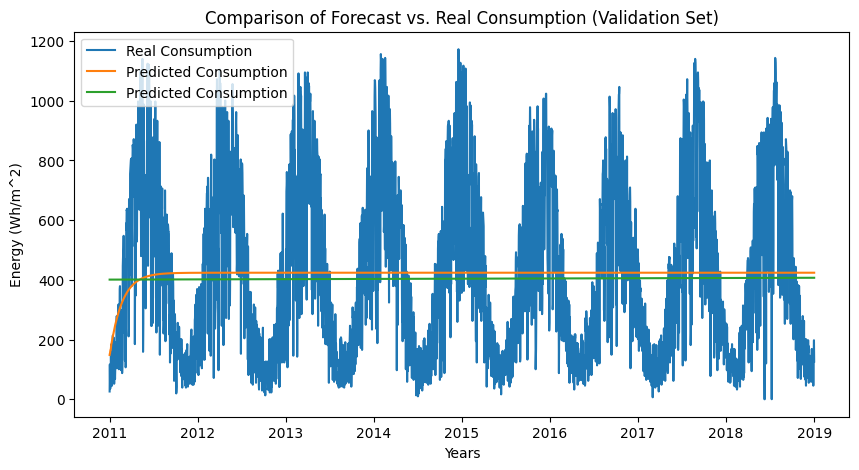

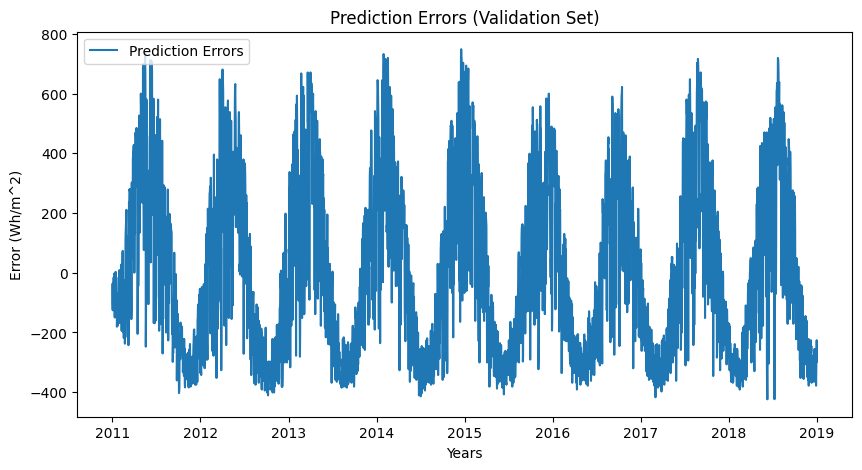

Mean Absolute Error (MAE) between predicted and real consumptions: 247.4400395233534
R^2 on the validation set: 0.501836448601928


In [ ]:
# answer to a

p, d, q = 10, 0, 0  
model = ARIMA(validation_set, order=(p, d, q))
arima_results = model.fit()

forecast = arima_results.forecast(steps=len(validation_set))

years = np.linspace(2011, 2019, num=len(validation_set))

# predicted consumption(validation_pred) oscille toujours autour de 400, le pb doit se trouver avant

plt.figure(figsize=(10, 5))
plt.plot(years, validation_set, label="Real Consumption")
plt.plot(years, forecast, label="Predicted Consumption")
plt.plot(years, validation_pred, label="Predicted Consumption")
plt.xlabel("Years")
plt.ylabel("Energy (Wh/m^2)")
plt.title("Comparison of Forecast vs. Real Consumption (Validation Set)")
plt.legend()
plt.show()

# answer to b 

validation_errors = validation_set - forecast

plt.figure(figsize=(10, 5))
plt.plot(years, validation_errors, label="Prediction Errors")
plt.xlabel("Years")
plt.ylabel("Error (Wh/m^2)")
plt.title("Prediction Errors (Validation Set)")
plt.legend()
plt.show()


# answer to c

sum = 0
x = len(validation_set)
for i in range(x):
    sum += abs(validation_set[i] - forecast[i])
error = sum/x
print(f"Mean Absolute Error (MAE) between predicted and real consumptions: {error}")

residuals = validation_set - forecast
sse = np.sum(residuals ** 2)
ssr = np.sum((validation_set - forecast.mean())**2)
sst = ssr + sse
r_squared = 1 - (sse / sst)
print(f"R^2 on the validation set: {r_squared}")